In [1]:
import locale
locale.setlocale(locale.LC_ALL,'en_US')

import pandas
import collections
import itertools
import numpy as np
import lifelines

from matplotlib import pyplot as plt

import matplotlib_venn
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

%matplotlib inline

In [2]:
FIG_SIZE = (5, 3)

In [5]:
data = pandas.read_csv('../data/github-cran-150601.csv', index_col=0)

data['Date'] = pandas.to_datetime(data['Date'])
data['Dependencies'] = data['Dependencies'].map(lambda x: [] if pandas.isnull(x) else x.split(' '))

data = data[['Package', 'Version', 'Date', 'InCRAN', 'InGitHub', 'Dependencies', 'Maintainer']]
alldata = data.copy()

In [6]:
#_github = data.query('InGitHub == 1')
#_cran = data.query('InCRAN == 1')

#_archived = pandas.read_csv('../data/cran-packages-150601.csv')
#_archived = _archived.query('archived == False').rename(columns={'package': 'Package'})

#_cran = _cran.merge(_archived[['Package']], how='inner', on=['Package'])
#data = pandas.concat([_github, _cran])

In [7]:
trivial_pkg = set(('R MASS Matrix base boot class cluster codetools compiler datasets foreign grDevices ' +
        'graphics grid lattice methods mgcv nlme nnet parallel rpart ' +
        'spatial splines stats stats4 survival tcltk tools translations utils').split(' '))

In [8]:
data = data.sort('Date')

dates = pandas.date_range(start='2014-06', end='2015-06', freq='2W')
ndata = collections.OrderedDict()

for date in dates:
    packages = data[data['Date'] <= date].drop_duplicates(['Package', 'InCRAN'], take_last=True)
    gh_packages = packages.query('InGitHub == 1')
    cran_packages = packages.query('InCRAN == 1')
    
    gh_packages_set = set(gh_packages['Package'])
    cran_packages_set = set(cran_packages['Package'])
    
    d = {'github': gh_packages_set,
         'cran': cran_packages_set, 
         'req_cran': set(), 
         'req_gh': set(), 
         'req_unknown': set(),
         'req_gh_or_unknown': set()}
    
    for ix, row in gh_packages.iterrows():
        package = row['Package']
        req_cran = False
        req_gh = False
        req_unknown = False
        
        for dep in row['Dependencies']:
            if dep in trivial_pkg:
                pass
            elif dep in cran_packages_set:
                req_cran = True
            elif dep in gh_packages_set:
                req_gh = True
            else:
                req_unknown = True
                
        if req_cran:
            d['req_cran'].add(package)
        if req_gh:
            d['req_gh'].add(package)
        if req_unknown:
            d['req_unknown'].add(package)

        if req_gh or req_unknown:
            d['req_gh_or_unknown'].add(package)
            
    ndata[date] = d

In [9]:
df = pandas.DataFrame.from_dict({d: {k: len(v) for k,v in p.iteritems()} for d, p in ndata.iteritems()}, orient='index')
df['req_gh_p'] = df['req_gh'] / df['github']
df['req_cran_p'] = df['req_cran'] / df['github']
df['req_unknown_p'] = df['req_unknown'] / df['github']
df['req_gh_or_unknown_p'] = df['req_gh_or_unknown'] / df['github']

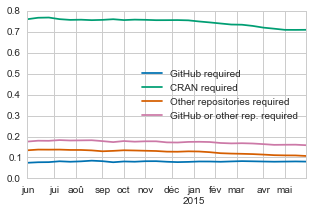

In [10]:
fig, ax = plt.subplots()

fig.set_size_inches(FIG_SIZE)

_ = df[['req_gh_p', 'req_cran_p', 'req_unknown_p', 'req_gh_or_unknown_p']]
_ = _.rename(columns={'req_gh_p': 'GitHub required', 
                      'req_cran_p': 'CRAN required', 
                      'req_unknown_p': 'Other repositories required',
                      'req_gh_or_unknown_p': 'GitHub or other rep. required'})
_.plot(ax=ax)

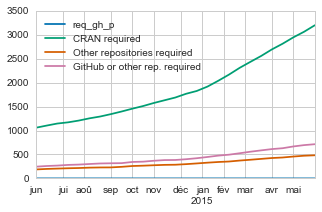

In [11]:
fig, ax = plt.subplots()

fig.set_size_inches(FIG_SIZE)

_ = df[['req_gh_p', 'req_cran', 'req_unknown', 'req_gh_or_unknown']]
_ = _.rename(columns={'req_gh': 'GitHub required', 
                      'req_cran': 'CRAN required', 
                      'req_unknown': 'Other repositories required',
                      'req_gh_or_unknown': 'GitHub or other rep. required'})
_.plot(ax=ax)

In [12]:
df

,github,req_unknown,req_gh,req_cran,req_gh_or_unknown,cran,req_gh_p,req_cran_p,req_unknown_p,req_gh_or_unknown_p
2014-06-01,1392,187,104,1059,245,6460,0.074713,0.760776,0.134339,0.176006
2014-06-15,1438,198,111,1104,259,6504,0.077191,0.767733,0.137691,0.180111
2014-06-29,1492,205,116,1147,268,6563,0.077748,0.768767,0.137399,0.179625
2014-07-13,1540,212,126,1172,282,6616,0.081818,0.761039,0.137662,0.183117
2014-07-27,1596,217,127,1209,289,6677,0.079574,0.757519,0.135965,0.181078
2014-08-10,1656,225,135,1256,301,6720,0.081522,0.758454,0.135870,0.181763
2014-08-24,1711,229,145,1294,312,6779,0.084746,0.756283,0.133840,0.182350
2014-09-07,1774,230,146,1344,316,6841,0.082300,0.757610,0.129651,0.178129
2014-09-21,1839,242,142,1399,319,6897,0.077216,0.760740,0.131593,0.173464
2014-10-05,1927,259,156,1458,344,6939,0.080955,0.756617,0.134406,0.178516


## Maintainers

In [19]:
import re

split_maintainer = re.compile(r'(.*) ?<(.*)>')

maintainers = data.dropna()

In [61]:
github_only = ['RMINC', 'sjemea', 'mapoland', 'ANTsR', 'rage', 'EflowStats']

In [82]:
_A = maintainers.query('InCRAN == 1').drop_duplicates('Package').groupby('Maintainer').count().sort('Package', ascending=False)[['Package']]
_A = _A.rename(columns={'Package': 'CRAN'})
_B = maintainers.query('InCRAN == 0').drop_duplicates('Package').groupby('Maintainer').count().sort('Package', ascending=False)[['Package']]
_B = _B.rename(columns={'Package': 'GitHub'})

_C = _A.join(_B, how='outer').fillna(0)
_C['total'] = _C['CRAN'] + _C['GitHub']
_C.sort('total', ascending=False)

,CRAN,GitHub,total
Maintainer,,,
Who to complain to <yourfault@somewhere.net>,0,462,462
Hadley Wickham <h.wickham@gmail.com>,31,20,51
Henrik Bengtsson <henrikb@braju.com>,18,25,43
Scott Chamberlain <myrmecocystus@gmail.com>,24,18,42
Dirk Eddelbuettel <edd@debian.org>,27,6,33
Robert Krzyzanowski <technoguyrob@gmail.com>,2,28,30
Thomas J. Leeper <thosjleeper@gmail.com>,8,20,28
Martin Maechler <maechler@stat.math.ethz.ch>,24,2,26
Jeroen Ooms <jeroen.ooms@stat.ucla.edu>,16,6,22


In [85]:
for ix, row in _C.sort('total', ascending=False).head(25).iterrows():
    
    pkg = maintainers[maintainers['Maintainer'] == ix]
    gh = pkg[pkg['InGitHub'] == 1].drop_duplicates('Package')
    cran = pkg[pkg['InCRAN'] == 1].drop_duplicates('Package')
    both = set(gh['Package']).intersection(set(cran['Package']))
    if len(both) == 0:
        continue
    print ix
    print '->', len(gh), 'on GH:', ', '.join(gh['Package'])
    print '->', len(cran), 'on CRAN:', ', '.join(cran['Package'])
    print '->', len(both), 'on both:', ', '.join(both)
    print
    print


Hadley Wickham <h.wickham@gmail.com>
-> 21 on GH: reshape, meifly, ggplot2, plyr, eval.with.details, reshape2, lubridate, testthat, stringr, devtools, evaluate, scales, web, httr, staticdoc, staticdocs, pryr, nullabor, DBI, rv, rv2
-> 35 on CRAN: reshape, butler, ggplot, classifly, meifly, ggplot2, clusterfly, scagnostics, hints, profr, plyr, stringr, mutatr, testthat, tourr, evaluate, lubridate, memoise, sinartra, helpr, nullabor, devtools, productplots, scales, hof, httr, gtable, roxygen2, hflights, dplyr, reshape2, rggobi, pryr, rappdirs, rvest
-> 14 on both: scales, pryr, httr, lubridate, evaluate, testthat, reshape2, plyr, ggplot2, reshape, meifly, devtools, stringr, nullabor


Henrik Bengtsson <henrikb@braju.com>
-> 26 on GH: aroma.light, R.filesets, R.methodsS3, R.oo, R.cache, R.huge, R.utils, R.matlab, R.rsp, aroma.cn.eval, aroma.cn, aroma.core, aroma.affymetrix, aroma.apd, R.menu, ACNE, aroma.agilent, calmate, R.archive, PSCBS, R.devices, aroma.seq, rmini, R.devices.rgl, matri

In [90]:
for ix, row in _C.sort('GitHub', ascending=False).query('CRAN == 0').head(12).iterrows():
    pkg = maintainers[maintainers['Maintainer'] == ix].drop_duplicates('Package')
    if len(pkg) > 100:
        continue # "Who to complain to"
    print ix
    print '->', len(pkg), 'on GH:', ', '.join(pkg['Package'])
    print
    print

Your Name <your@email.com>
-> 16 on GH: pkgKitten, gbra, knitroR, PesPila, editR, learnpkg, voteR, cogarchfmlyr, dispersim, relSim, lawsonLoc, odeintr, mtusRlocal, cb.city, CreatePackageTemp, wordclouds


Keith Hughitt <khughitt@umd.edu>
-> 14 on GH: org.LmjF.tritryp.db, org.TcCLB.esmer.tritryp.db, org.TGME49.toxo.db, TxDb.TcruziCLBrenerEsmer.tritryp9.genes, TxDb.TgondiiME49.toxo13.genes, Leishmania.major.Friedlin, Trypanosoma.cruzi.CLBrener.Esmeraldo, Toxoplasma.gondii.ME49, org.TcCLB.nonesmer.tritryp.db, TxDb.TcruziCLBrenerNonEsmer.tritryp9.genes, Trypanosoma.cruzi.CLBrener.NonEsmeraldo, Trypanosoma.cruzi.CLBrener, org.TcCLB.tritryp.db, org.Tb927.tritryp.db


Dave Lorenz <lorenz@usgs.gov>
-> 13 on GH: LOADEST, USGSwsData, USGSwsBase, rloadest, USGSwsGraphs, USGSwsStats, USGSwsQW, restrend, smwrData, smwrGraphs, smwrBase, smwrQW, smwrStats


Guangchuang Yu <guangchuangyu@gmail.com>
-> 13 on GH: MLclass, mlass, GOSemSim, clusterProfiler, ReactomePA, DOSE, ChIPseeker, bitr, aqua, skleid